In [4]:
import os
from classes.VAE import VAE
from utils.callbacks import *
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor
from torchvision.io import read_image
from torchsummary import summary

from torch import distributions as D
import wandb

from imutils import paths
import matplotlib.pyplot as plt
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


True

In [2]:
encoder_architecture=[[1,512],[1,256],[1,128],[1,64],[1,32]]
decoder_architecture=[[3,64],[2,128],[1,256],[0,384],[0,512]]

latent_dim=1024
input_dim=(3,128,128)


config={"dataset":"celebA", "type":"VAE","encoder_architecture":encoder_architecture,"decoder_architecture":decoder_architecture}
config["latent_dim"]=latent_dim
config["input_dim"]=input_dim

model=VAE(input_dim=input_dim,latent_dim=latent_dim,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture)

/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [3]:
images_dir=r"C:\Users\matte\Dataset\tor_vergata\Dataset\Img\img_align_celeba"
images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"

#other important definitions

EPOCHS=20
BS=8
INIT_LR=1e-4

config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR


In [4]:
summary(model.encoder,(3,128,128),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 64, 64]          25,088
            Conv2d-2          [-1, 512, 64, 64]       2,359,808
       BatchNorm2d-3          [-1, 512, 64, 64]           1,024
            Conv2d-4          [-1, 512, 64, 64]       2,359,808
       BatchNorm2d-5          [-1, 512, 64, 64]           1,024
              ReLU-6          [-1, 512, 64, 64]               0
            Conv2d-7          [-1, 512, 64, 64]       2,359,808
       BatchNorm2d-8          [-1, 512, 64, 64]           1,024
         LeakyReLU-9          [-1, 512, 64, 64]               0
    ResidualBlock-10          [-1, 512, 64, 64]               0
     ConvResBlock-11          [-1, 512, 64, 64]               0
           Conv2d-12          [-1, 256, 32, 32]       2,097,408
           Conv2d-13          [-1, 256, 32, 32]         590,080
      BatchNorm2d-14          [-1, 256,

In [5]:
summary(model.decoder,(latent_dim,),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,049,600
         Unflatten-2             [-1, 64, 4, 4]               0
   ConvTranspose2d-3             [-1, 64, 8, 8]          65,600
             PReLU-4             [-1, 64, 8, 8]               1
            Conv2d-5             [-1, 64, 8, 8]          36,928
       BatchNorm2d-6             [-1, 64, 8, 8]             128
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          36,928
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        LeakyReLU-12             [-1, 64, 8, 8]               0
    ResidualBlock-13             [-1, 64, 8, 8]               0
           Conv2d-14             [-1, 6

## Dataloaders

In [6]:
class ImageDataset(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)/255.
        return image

In [7]:
transforms=Compose([
 Resize((128,128)),
])



In [8]:
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(images_dir))


train_len=int(0.8*len(imagePaths))  #0.8
val_len=int(0.1*len(imagePaths))     #0.1
test_len=int(0.1*len(imagePaths))

train_imgs=imagePaths[:train_len]                                #      80% for training
val_imgs=imagePaths[train_len:train_len+val_len]                 #      10% for validation
test_imgs=imagePaths[train_len+val_len:]                         #      10% for testing

print(f"[TRAINING]\t {len(train_imgs)}\n[VALIDATION]\t {len(val_imgs)}\n[TEST]\t\t {len(test_imgs)}")

[INFO] loading image paths...
[TRAINING]	 138545
[VALIDATION]	 17318
[TEST]		 17319


In [9]:
train_dataset=ImageDataset(train_imgs,transform=transforms)
val_dataset=ImageDataset(val_imgs,transform=transforms)
test_dataset=ImageDataset(test_imgs,transform=transforms)

train_dataloader=DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=BS)
test_dataloader=DataLoader(test_dataset, batch_size=BS)


## Train Loop

In [10]:
base_path="models/vae"
os.makedirs(base_path,exist_ok=True)

In [11]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


In [12]:
wandb.init(project="NeuroGEN_Pytorch",config=config)

Epoch 0: 100%|█| 17319/17319 [32:05<00:00,  8.99batch/s, kl_loss=0.00391, loss=0
Val 0: 100%|█| 2165/2165 [01:40<00:00, 21.51batch/s, val_kl_loss=0.00391, val_lo


(6, 128, 128, 3) (6, 128, 128, 3)


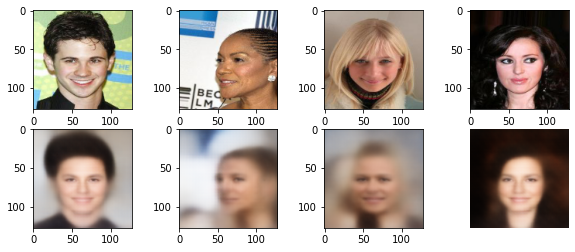

Epoch 1: 100%|█| 17319/17319 [31:55<00:00,  9.04batch/s, kl_loss=0.0033, loss=0.
Val 1: 100%|█| 2165/2165 [01:37<00:00, 22.15batch/s, val_kl_loss=0.0033, val_los


(6, 128, 128, 3) (6, 128, 128, 3)


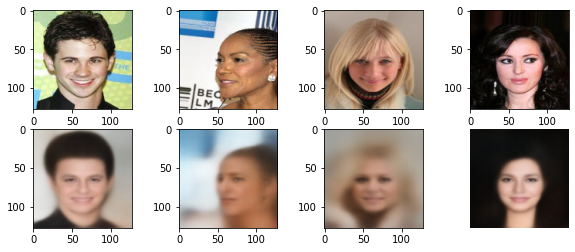

Epoch 2:  13%|▏| 2284/17319 [04:18<27:49,  9.01batch/s, kl_loss=0.0023, loss=0.0

In [ ]:

#model.load_state_dict(torch.load(r"models/vae/model.ckp"))

optimizer=torch.optim.Adam(model.parameters(),lr=INIT_LR)
model.to(device)

model.fit(train_dataloader=train_dataloader,val_dataloader=val_dataloader,epochs=EPOCHS,optimizer=optimizer,device=device,wandb_log=True,save_model=base_path,early_stop=3)

In [18]:
torch.save(model.state_dict(), os.path.join(base_path,"model.pt"))


## Check on test set

In [21]:
x=next(iter(test_dataloader))


x2=model(x.to(device))

(8, 128, 128, 3) (8, 128, 128, 3)


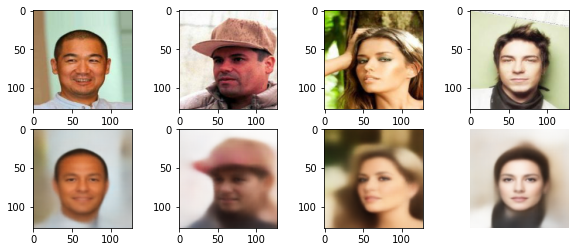

In [24]:
visualize(x.cpu().permute(0,2,3,1).numpy(),x2.cpu().permute(0,2,3,1).detach().numpy())